In [1]:
cd ..

/Users/sgcindy.zhang/Documents/projects/airbnb-ml


In [2]:
import src.transform as trans
import numpy as np

In [3]:
import s3fs
import pyarrow.parquet as pq
# import missingno as msno

s3 = s3fs.S3FileSystem()

df = pq.ParquetDataset('s3://airbnb-barcelona/valid/currentDate=2020-03-11', filesystem=s3).read_pandas().to_pandas()

In [4]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

def linear_reg_model_training(X_train, y_train, X_test):
    params={}
    linear=LinearRegression(fit_intercept=True)
    grid_search=GridSearchCV(linear, params, cv=5, scoring=('r2'), n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model =grid_search.best_estimator_
    return best_model.predict(X_test)

In [6]:
# df.head()

In [7]:
# has_availability: True, same value
# license: TODO
# amenities: TODO
# property_type: TODO
# host_verifications: TODO

In [8]:
df["neighbourhood_group_cleansed"].head()

0    Sant Martí
1      Eixample
2    Sant Martí
3        Gràcia
4        Gràcia
Name: neighbourhood_group_cleansed, dtype: object

In [9]:
df = df.loc[df['market'] == "Barcelona"]


In [10]:
dropped_cols_df = trans.drop_columns(df)
dropped_cols_df["neighbourhood_group_cleansed"].head()

0    Sant Martí
1      Eixample
2    Sant Martí
3        Gràcia
4        Gràcia
Name: neighbourhood_group_cleansed, dtype: object

In [11]:
dropped_cols_rows_df = trans.drop_rows(dropped_cols_df)
dropped_cols_df["neighbourhood_group_cleansed"].head()

0    Sant Martí
1      Eixample
2    Sant Martí
3        Gràcia
4        Gràcia
Name: neighbourhood_group_cleansed, dtype: object

In [12]:
dropped_cols_rows_df = trans.fill_missing_data(dropped_cols_rows_df)

In [13]:
dropped_cols_rows_df = trans.convert_boolean_to_float(dropped_cols_rows_df)
dropped_cols_rows_df.head()

,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,is_location_exact,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,within an hour,0.99,0,46.0,46.0,1,1,Sant Martí,41.40889,2.18555,1,Entire home/apt,6.0,1.0,2.0,4.0,Real Bed,130.0,150.0,42.0,2.0,25.0,3.0,730.0,3.0,730.0,0.0,0.0,29.0,304.0,1.0,0.0,80.0,10.0,10.0,2.0,10.0,10.0,8.0,0,flexible,0,0,30.0,30.0,0.0,0.0
1,within an hour,0.99,0,46.0,46.0,1,1,Eixample,41.40420,2.17306,1,Entire home/apt,8.0,2.0,3.0,6.0,Real Bed,60.0,150.0,50.0,2.0,30.0,1.0,1125.0,3.9,1125.0,15.0,24.0,50.0,312.0,20.0,15.0,87.0,9.0,9.0,10.0,10.0,9.0,9.0,1,strict_14_with_grace_period,0,0,30.0,30.0,0.0,0.0
2,within an hour,1.00,1,5.0,5.0,1,1,Sant Martí,41.41203,2.22114,0,Entire home/apt,6.0,2.0,3.0,5.0,Real Bed,210.0,300.0,80.0,3.0,10.0,3.0,30.0,3.1,1125.0,29.0,59.0,89.0,359.0,51.0,17.0,95.0,10.0,10.0,10.0,10.0,9.0,9.0,1,strict_14_with_grace_period,0,1,2.0,2.0,0.0,0.0
3,within an hour,1.00,1,1.0,1.0,1,1,Gràcia,41.40145,2.15645,1,Private room,2.0,1.0,1.0,1.0,Real Bed,32.0,0.0,0.0,1.0,25.0,1.0,730.0,1.0,730.0,13.0,13.0,13.0,46.0,268.0,44.0,95.0,10.0,9.0,10.0,10.0,10.0,10.0,1,strict_14_with_grace_period,1,1,1.0,0.0,1.0,0.0
4,within an hour,0.92,0,39.0,39.0,1,0,Gràcia,41.40950,2.15938,1,Entire home/apt,4.0,1.0,1.0,1.0,Real Bed,60.0,200.0,58.0,4.0,0.0,1.0,27.0,2.1,27.0,16.0,33.0,58.0,324.0,182.0,32.0,92.0,9.0,9.0,8.0,9.0,9.0,9.0,1,strict_14_with_grace_period,0,0,39.0,39.0,0.0,0.0


In [14]:
dropped_cols_rows_df["neighbourhood_group_cleansed"].value_counts()

Eixample               6679
Ciutat Vella           4928
Sants-Montjuïc         2350
Sant Martí             2161
Gràcia                 1759
Sarrià-Sant Gervasi     755
Horta-Guinardó          672
Les Corts               417
Sant Andreu             354
Nou Barris              249
Name: neighbourhood_group_cleansed, dtype: int64

In [15]:
dropped_cols_rows_df = trans.fill_missing_data_with_mean(dropped_cols_rows_df)

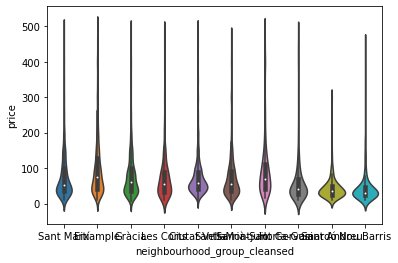

In [16]:
import seaborn as sns
sub_6=dropped_cols_rows_df[dropped_cols_rows_df.price < 500]
viz_2=sns.violinplot(data=sub_6, x='neighbourhood_group_cleansed', y='price')


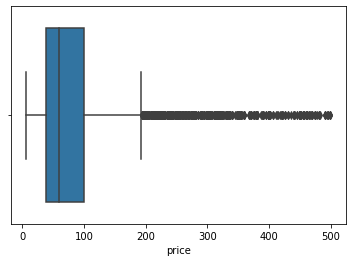

In [17]:
sub_6=dropped_cols_rows_df[dropped_cols_rows_df.price < 500]
ax = sns.boxplot(x=sub_6["price"])


In [18]:
dropped_cols_rows_encoding_df = trans.one_hot_encoding(dropped_cols_rows_df)
dropped_cols_rows_encoding_df.head()

,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,host_response_time_N/A,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,neighbourhood_group_cleansed_Ciutat Vella,neighbourhood_group_cleansed_Eixample,neighbourhood_group_cleansed_Gràcia,neighbourhood_group_cleansed_Horta-Guinardó,neighbourhood_group_cleansed_Les Corts,neighbourhood_group_cleansed_Nou Barris,neighbourhood_group_cleansed_Sant Andreu,neighbourhood_group_cleansed_Sant Martí,neighbourhood_group_cleansed_Sants-Montjuïc,neighbourhood_group_cleansed_Sarrià-Sant Gervasi
0,0.99,0,46.0,46.0,1,1,41.40889,2.18555,1,6.0,1.0,2.0,4.0,130.0,150.0,42.0,2.0,25.0,3.0,730.0,3.0,730.0,0.0,0.0,29.0,304.0,1.0,0.0,80.0,10.0,10.0,2.0,10.0,10.0,8.0,0,0,0,30.0,30.0,0.0,0.0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.99,0,46.0,46.0,1,1,41.40420,2.17306,1,8.0,2.0,3.0,6.0,60.0,150.0,50.0,2.0,30.0,1.0,1125.0,3.9,1125.0,15.0,24.0,50.0,312.0,20.0,15.0,87.0,9.0,9.0,10.0,10.0,9.0,9.0,1,0,0,30.0,30.0,0.0,0.0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,1.00,1,5.0,5.0,1,1,41.41203,2.22114,0,6.0,2.0,3.0,5.0,210.0,300.0,80.0,3.0,10.0,3.0,30.0,3.1,1125.0,29.0,59.0,89.0,359.0,51.0,17.0,95.0,10.0,10.0,10.0,10.0,9.0,9.0,1,0,1,2.0,2.0,0.0,0.0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,1.00,1,1.0,1.0,1,1,41.40145,2.15645,1,2.0,1.0,1.0,1.0,32.0,0.0,0.0,1.0,25.0,1.0,730.0,1.0,730.0,13.0,13.0,13.0,46.0,268.0,44.0,95.0,10.0,9.0,10.0,10.0,10.0,10.0,1,1,1,1.0,0.0,1.0,0.0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
4,0.92,0,39.0,39.0,1,0,41.40950,2.15938,1,4.0,1.0,1.0,1.0,60.0,200.0,58.0,4.0,0.0,1.0,27.0,2.1,27.0,16.0,33.0,58.0,324.0,182.0,32.0,92.0,9.0,9.0,8.0,9.0,9.0,9.0,1,0,0,39.0,39.0,0.0,0.0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0


In [19]:
total_price_df = dropped_cols_rows_encoding_df.copy()
total_price_df["total_price"] = total_price_df["price"] + total_price_df["cleaning_fee"]
total_price_df=total_price_df.drop(["price", "cleaning_fee"], axis=1)

In [20]:
import matplotlib.pyplot as plt


In [40]:
def drop_corr_cols():
    dropped_columns = ["bed_type_Pull-out Sofa", "room_type_Private room", "review_scores_communication", "review_scores_value",'calculated_host_listings_count_entire_homes','availability_60','availability_90','number_of_reviews_ltm','review_scores_accuracy','host_total_listings_count']
    return dropped_cols_rows_encoding_df.drop(dropped_columns, axis=1)

In [41]:
dropped_cols_rows_encoding_df = drop_corr_cols()
# dropped_cols_rows_encoding_df.head()

# Linear Regression For Reviews

In [26]:
review_y = dropped_cols_rows_encoding_df[["review_scores_rating"]]
review_X = dropped_cols_rows_encoding_df.loc[:, dropped_cols_rows_encoding_df.columns != 'review_scores_rating']
dropped_cols_rows_encoding_df.head()

,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,host_response_time_N/A,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,neighbourhood_group_cleansed_Ciutat Vella,neighbourhood_group_cleansed_Eixample,neighbourhood_group_cleansed_Gràcia,neighbourhood_group_cleansed_Horta-Guinardó,neighbourhood_group_cleansed_Les Corts,neighbourhood_group_cleansed_Nou Barris,neighbourhood_group_cleansed_Sant Andreu,neighbourhood_group_cleansed_Sant Martí,neighbourhood_group_cleansed_Sants-Montjuïc,neighbourhood_group_cleansed_Sarrià-Sant Gervasi
0,0.99,0,46.0,46.0,1,1,41.40889,2.18555,1,6.0,1.0,2.0,4.0,130.0,150.0,42.0,2.0,25.0,3.0,730.0,3.0,730.0,0.0,0.0,29.0,304.0,1.0,0.0,80.0,10.0,10.0,2.0,10.0,10.0,8.0,0,0,0,30.0,30.0,0.0,0.0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.99,0,46.0,46.0,1,1,41.40420,2.17306,1,8.0,2.0,3.0,6.0,60.0,150.0,50.0,2.0,30.0,1.0,1125.0,3.9,1125.0,15.0,24.0,50.0,312.0,20.0,15.0,87.0,9.0,9.0,10.0,10.0,9.0,9.0,1,0,0,30.0,30.0,0.0,0.0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,1.00,1,5.0,5.0,1,1,41.41203,2.22114,0,6.0,2.0,3.0,5.0,210.0,300.0,80.0,3.0,10.0,3.0,30.0,3.1,1125.0,29.0,59.0,89.0,359.0,51.0,17.0,95.0,10.0,10.0,10.0,10.0,9.0,9.0,1,0,1,2.0,2.0,0.0,0.0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,1.00,1,1.0,1.0,1,1,41.40145,2.15645,1,2.0,1.0,1.0,1.0,32.0,0.0,0.0,1.0,25.0,1.0,730.0,1.0,730.0,13.0,13.0,13.0,46.0,268.0,44.0,95.0,10.0,9.0,10.0,10.0,10.0,10.0,1,1,1,1.0,0.0,1.0,0.0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
4,0.92,0,39.0,39.0,1,0,41.40950,2.15938,1,4.0,1.0,1.0,1.0,60.0,200.0,58.0,4.0,0.0,1.0,27.0,2.1,27.0,16.0,33.0,58.0,324.0,182.0,32.0,92.0,9.0,9.0,8.0,9.0,9.0,9.0,1,0,0,39.0,39.0,0.0,0.0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [28]:
X_train, X_test, y_train, y_test = train_test_split(review_X, 
                                                    review_y, 
                                                    random_state=42, 
                                                    test_size=0.2)
grid_y_pred = linear_reg_model_training(X_train, y_train, X_test)
print(r2_score(y_test, grid_y_pred))
print(mean_squared_error (y_test, grid_y_pred))

0.8100735991595966
14.1218209437631


In [29]:
sig_X = trans.get_sig_columns(review_X, review_y)
X_train_sig, X_test_sig, y_train_sig, y_test_sig = train_test_split(sig_X, 
                                                    review_y, 
                                                    random_state=42, 
                                                    test_size=0.2)
grid_y_pred_sig = linear_reg_model_training(X_train_sig, y_train_sig, X_test_sig)
print(r2_score(y_test_sig, grid_y_pred_sig))
print(mean_squared_error (y_test_sig, grid_y_pred_sig))                        

0.8092264977999999
14.18480646693686


# Total Price

In [30]:
# price prediction
total_price_y = total_price_df["total_price"]
total_price_X = total_price_df.copy().drop(["total_price"], axis=1)

Linear Regression For Total Price

In [31]:
X_train_total_price, X_test_total_price, y_train_total_price, y_test_total_price = train_test_split(total_price_X, 
                                                    total_price_y, 
                                                    random_state=42, 
                                                    test_size=0.2)
grid_y_pred_total_price = linear_reg_model_training(X_train_total_price, y_train_total_price, X_test_total_price)
print(r2_score(y_test_total_price, grid_y_pred_total_price))
print(mean_squared_error (y_test_total_price, grid_y_pred_total_price))

0.12627399936399797
143341.66390268863


In [32]:
sig_X_total_price = trans.get_sig_columns(total_price_X, total_price_y)
X_train_sig_total_price, X_test_sig_total_price, y_train_sig_total_price, y_test_sig_total_price = train_test_split(sig_X_total_price, 
                                                    total_price_y, 
                                                    random_state=42, 
                                                    test_size=0.2)
grid_y_pred_sig_total_price = linear_reg_model_training(X_train_sig_total_price, y_train_sig_total_price, X_test_sig_total_price)
print(r2_score(y_test_sig_total_price, grid_y_pred_sig_total_price))
print(mean_squared_error (y_test_sig_total_price, grid_y_pred_sig_total_price))    

0.12581969605810983
143416.195954768


In [33]:
def polynomial_model_training(X_train,X_test, y_train,  y_test):
    learner=LinearRegression(fit_intercept=True, )
    poly=PolynomialFeatures(degree=2)

    X_train_poly=poly.fit_transform(X_train)
    learner.fit(X_train_poly, y_train)

    X_test_poly=poly.fit_transform(X_test)
    y_test_pred=learner.predict(X_test_poly)

    print(r2_score(y_test_pred, y_test))
    print(mean_squared_error(y_test_pred, y_test))

In [34]:
from sklearn.preprocessing import PolynomialFeatures
# polynomial_model_training(X_train_price, X_test_price, y_train_price, y_test_price)

In [35]:
# polynomial_model_training(X_train_sig_price, X_test_sig_price, y_train_sig_price, y_test_sig_price)

Decision Tree For Total Price

In [29]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor

def decision_tree_training(X_train, X_test, y_train,  y_test):
    tree=DecisionTreeRegressor(min_samples_leaf=2)
    tree.fit(X_train, y_train)
    y_pred=tree.predict(X_test)

    print(r2_score(y_pred, y_test))
    print(mean_squared_error(y_pred, y_test))

In [63]:
decision_tree_training(X_train_total_price,X_test_total_price, y_train_total_price, y_test_total_price)

0.45758805152180604
135523.05925925926


In [55]:
decision_tree_training(X_train_sig_total_price, X_test_sig_total_price, y_train_sig_total_price, y_test_sig_total_price)

0.5295462515878144
91091.35211835451


# Price

In [43]:
price_y = dropped_cols_rows_encoding_df[["price"]]
price_X = dropped_cols_rows_encoding_df.loc[:, dropped_cols_rows_encoding_df.columns != 'price']

Linear Regression

In [44]:
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(price_X, 
                                                    price_y, 
                                                    random_state=42, 
                                                    test_size=0.2)
grid_y_pred_price = linear_reg_model_training(X_train_price, y_train_price, X_test_price)
print(r2_score(y_test_price, grid_y_pred_price))
print(mean_squared_error (y_test_price, grid_y_pred_price))

0.1083632910522091
142456.90330019532


Decission Tree

In [68]:
decision_tree_training(X_train_price, X_test_price, y_train_price, y_test_price)

0.4525363105887841
108972.18808938087


Normalization

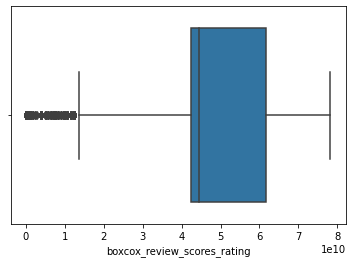

In [42]:
from scipy import stats
rating_price = dropped_cols_rows_encoding_df[["review_scores_rating","price"]]
rating_price["log_price"] = np.log(rating_price["price"])
rating_price["org_price"] = np.exp(rating_price["log_price"])
rating_price["boxcox_review_scores_rating"] = stats.boxcox(rating_price["review_scores_rating"])[0]
ax = sns.boxplot(x=rating_price["boxcox_review_scores_rating"])
# ax = sns.scatterplot(x="boxcox_review_scores_rating", y="log_price", data=rating_price)

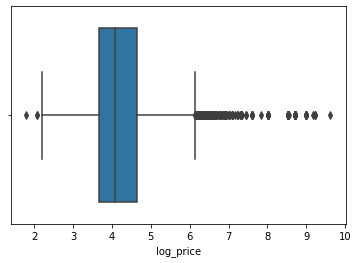

In [43]:
ax = sns.boxplot(x=rating_price["log_price"])

In [44]:
norm_price_training_df = dropped_cols_rows_encoding_df.copy()
norm_price_training_df["price"] = rating_price["log_price"]
norm_price_training_df["review_scores_rating"] = rating_price["boxcox_review_scores_rating"]

In [49]:
norm_price_y = norm_price_training_df["price"]
norm_price_X = norm_price_training_df.copy().drop(["price"], axis=1)

X_train_norm_price, X_test_norm_price, y_train_norm_price, y_test_norm_price = train_test_split(norm_price_X,
                                                    norm_price_y, 
                                                    random_state=42, 
                                                    test_size=0.2)
decision_tree_training(X_train_norm_price, X_test_norm_price, y_train_norm_price, y_test_norm_price)
# sig_X_price = trans.get_sig_columns(price_X, price_y)
# X_train_sig_price, X_test_sig_price, y_train_sig_price, y_test_sig_price = train_test_split(sig_X_price, 
#                                                     price_y, 
#                                                     random_state=42, 
#                                                     test_size=0.2)
# decision_tree_training(X_train_sig_price, X_test_sig_price, y_train_sig_price, y_test_sig_price)

0.5153308926848477
0.3414286277338677
